In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# %matplotlib notebook

In [2]:
# set some global parameters for the model

l = 20 # number of spins per dimension
n = l*l # total number of spins

h = 0. # external field
J = 1. # strength of the spin-spin coupling

# let's use units in which k_B = 1.
Tc = 2.269 # critical temperature for 2D Ising with J=1, h=0, k_B=1.
T = 2.0 # initial temperature
beta = 1/T # initial value of beta

In [3]:
# functions to initialize the configuration

def init_lattice(l):
    return 2*np.random.randint(2, size=(l,l))-1

def draw_lattice(lattice_conf):
    plt.imshow(lattice_conf)

In [4]:
# sum over the neighbors of spin i
# note that we use "periodic boundary conditions" so a spin at the right edge is
# "neighboring" the a spin on the left edge. This ensures that there are not boundary effects.
def compute_neighsum(lattice_conf, i, j):
    neighsum = lattice_conf[(i+1)%l,j]
    neighsum += lattice_conf[(i-1)%l,j]
    neighsum += lattice_conf[i,(j+1)%l]
    neighsum += lattice_conf[i,(j-1)%l]
    return neighsum

# compute the total energy for the lattice model
def compute_energy(lattice_conf):
    energy = 0.
    for i in range(l):
        for j in range(l):
            energy += -h * lattice_conf[i,j]
            energy += -0.5 * J * compute_neighsum(lattice_conf,i,j) * lattice_conf[i,j] # factor of 2 because the pair i,j is visited twice in the loop
    return energy

In [5]:
def compute_delta_e(lattice_conf, i, j):
    # implement this function!
    # return the energy difference associated with flipping
    # the spin indexed by i,j
    # Note: you do not need to compute the total energy!
    delta_energy = 0.0
    delta_energy += -h * (-lattice_conf[i,j] - lattice_conf[i,j])
    delta_energy += -1.0 * J * compute_neighsum(lattice_conf,i,j) * (-lattice_conf[i,j] - lattice_conf[i,j]) # factor of 2 because the pair i,j is visited twice in the loop
    return delta_energy

In [6]:
def monte_carlo_step(lattice_conf, beta):
    # select a random site to flip
    i,j = np.random.randint(l, size=2)
    # compute the energy difference of flipping spin i,j
    delta_e = compute_delta_e(lattice_conf,i,j)
    # TODO! accept or reject the move using the Metropolis criterion
    prob_acc = np.min([1.0, np.exp(-beta * delta_e)])
    if np.random.rand() < prob_acc:
        lattice_conf[i,j] *= -1
        return lattice_conf
    else:
        return lattice_conf

In [7]:
def run_mc_sweep(lattice_conf, beta):
    for attempt in range(n):
        lattice_conf = monte_carlo_step(lattice_conf, beta)
    return lattice_conf

In [8]:
def run_trajectory(lattice_conf, n_sweeps, beta):
    # traj = np.zeros([n_steps, l, l], dtype=np.int)
    traj = np.zeros([n_sweeps, l, l], dtype=int)
    for sweep in tqdm(range(n_sweeps), desc='sweep'):
        lattice_conf = run_mc_sweep(lattice_conf, beta)
        traj[sweep] = lattice_conf
    return traj

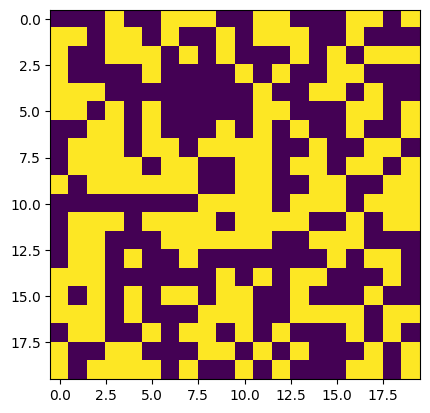

In [9]:
# example plotting the initial lattice
conf = init_lattice(l)
draw_lattice(conf)

In [10]:
# run a trajectory with 1000 mc sweeps
n_sweeps = 1000
traj = run_trajectory(conf, n_sweeps, beta)

sweep: 100%|██████████| 1000/1000 [00:23<00:00, 43.13it/s]


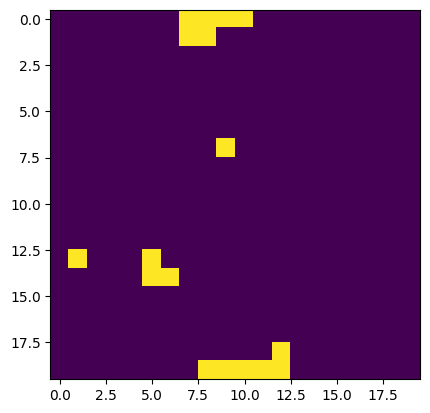

In [11]:
# You can run this function to visualize the trajectory
fig = plt.figure()
ax = plt.gca()

im = ax.imshow(traj[0])  # set initial display dimensions

def animate_func(i):
    im.set_array(traj[i])
    return [im]

# ani = FuncAnimation(fig, animate_func)
ani = FuncAnimation(fig, animate_func, frames=len(traj), cache_frame_data=False)
ani.save('ising.gif', writer='pillow', fps=10)
plt.show()

In [ ]:
def compute_running_m(traj, burn_in=0):
    traj_cut = traj[burn_in:]
    cumulative_sum = np.cumsum(np.mean(traj_cut, axis=(1, 2)))
    running_mean = cumulative_sum / np.arange(1, len(traj_cut) + 1)
    return running_mean

def compute_m(traj, burn_in=100):
    traj_cut = traj[burn_in:, ...]
    mean = np.mean(traj_cut)
    return mean

def compute_avg_e(traj, burn_in=100):
    traj_cut = traj[burn_in:, ...]
    avg_e = 0.0
    for j in range(traj_cut.shape[0]):
        avg_e += compute_energy(traj_cut[j, ...])
    return avg_e / traj_cut.shape[0]

def compute_var_e(traj, burn_in=100):
    avg_e = compute_avg_e(traj=traj, burn_in=burn_in)
    traj_cut = traj[burn_in:, ...]
    var_e = 0.0
    for j in range(traj_cut.shape[0]):
        var_e += (compute_energy(traj_cut[j, ...]) - avg_e)**2
    return var_e / traj_cut.shape[0]

In [ ]:
# TODO, plot the running average <M> as a function of the number of samples
running_m = compute_running_m(traj, burn_in=0)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(running_m)), running_m, color='blue', linewidth=2)

# plt.title('Running Average <M> vs Number of Samples', fontsize=16, fontweight='bold')
plt.xlabel('Trajectory Time', fontsize=12)
plt.ylabel(r'Running Average $<M>$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.savefig('running_avg.png', dpi=300, bbox_inches='tight')
plt.clf()

running_m_burn100 = compute_running_m(traj, burn_in=100)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(100, len(running_m)), running_m_burn100, color='blue', linewidth=2)

# plt.title('Running Average <M> vs Number of Samples', fontsize=16, fontweight='bold')
plt.xlabel('Trajectory Time', fontsize=12)
plt.ylabel(r'Running Average $<M>$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.savefig('running_avg_burn100.png', dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Example, compute the average of <M> for h in the range(-0.5, 0.5)

T=2.0
beta = 1/T

hs = np.linspace(-0.5, 0.5, 10)
ms = np.zeros(10)
i=0
for h_field in hs:
    h = h_field
    conf = init_lattice(l) # important to reinitialize
    traj = run_trajectory(conf, 500, beta)
    ms[i] = compute_m(traj)
    i+=1

sweep: 100%|██████████| 500/500 [00:08<00:00, 58.41it/s]


In [ ]:
# TODO plot <M> vs. h
plt.figure(figsize=(10, 6))
plt.plot(hs, ms, 'o-', color='#1f77b4', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$h$', fontsize=14)
plt.ylabel(r'$\langle M \rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-0.55, 0.55)
plt.tight_layout()
plt.savefig('M_vs_h.png', dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 1000x600 with 0 Axes>

In [ ]:
# make sure to set h=0!
h=0.
Ts = np.linspace(1.0, 4.0, 10)
es = np.zeros(10)
var_es = np.zeros(10)
i=0
for Temp in Ts:
    T = Temp
    conf = init_lattice(l)
    traj = run_trajectory(conf, 500, 1/T)
    es[i] = compute_avg_e(traj)
    var_es[i] = compute_var_e(traj)
    i+=1

sweep: 100%|██████████| 500/500 [00:09<00:00, 53.64it/s]


In [ ]:
# TODO plot <E> vs T
plt.figure(figsize=(10, 6))
plt.plot(Ts, es, 'o-', color='#1f77b4', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$T$', fontsize=14)
plt.ylabel(r'$\langle E \rangle$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(Ts[0] - 0.1, Ts[-1] + 0.1)
plt.tight_layout()
plt.savefig('E_vs_T.png', dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 1000x600 with 0 Axes>

In [ ]:
# TODO using the relation between var(E) and C_v, plot C_v vs. T
plt.figure(figsize=(10, 6))
plt.plot(Ts, var_es, 'o-', color='#ff7f0e', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$T$', fontsize=14)
plt.ylabel(r'$\langle E^2 \rangle - \langle E \rangle^2$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(Ts[0] - 0.1, Ts[-1] + 0.1)
plt.tight_layout()
plt.savefig('varE_vs_T.png', dpi=300, bbox_inches='tight')
plt.clf()

cv = var_es / Ts**2
plt.figure(figsize=(10, 6))
plt.plot(Ts, cv, 'o-', color='#ff7f0e', markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=1.5)
plt.xlabel(r'$T$', fontsize=14)
plt.ylabel(r'$C_V$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(Ts[0] - 0.1, Ts[-1] + 0.1)
plt.tight_layout()
plt.savefig('CV_vs_T.png', dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>